In [1]:
import pandas as pd

In [3]:
df_poi_per_district = pd.read_pickle("savedDF_POI_per_district.pickle")
df_poi_per_district.head()

,NAME,TYPE,geometry,restaurant,Bicycle_park,Bus,Railway_station_entrance_exit,Convenience Store,Scenic_spot,Sport
0,??,2,POLYGON Z ((121.4216787977396 30.6847124112995...,0,0,0,0,0,0,0
1,???,2,POLYGON Z ((121.4119888989075 30.6937387337238...,0,0,0,0,0,0,0
2,???,2,POLYGON Z ((121.4016307330431 30.7071734919907...,0,0,0,0,0,0,0
3,????,2,POLYGON Z ((121.3368669670694 30.7380603821550...,748,197,0,0,134,28,229
4,????,2,POLYGON Z ((121.2514316037695 30.7917653095429...,616,335,0,3,163,9,111


In [26]:
target = pd.read_pickle("./dataset/TARGET-communities-extract-wellbeing.pkl")
header = target[0]
df_target = pd.DataFrame(data=target, columns=header)
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
0,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807


In [ ]:
df_target = df_target.drop(df_target.index[0])

# Conversion

In [28]:
df_target = df_target[df_target['clean']!= '']
df_target = df_target[df_target['smell']!= '']
df_target = df_target[df_target['noise']!= '']
df_target = df_target[df_target['longitude']!= '']
df_target = df_target[df_target['latitude']!= '']


df_target['clean'] = df_target['clean'].apply(lambda x: float(x))
df_target['smell'] = df_target['smell'].apply(lambda x: float(x))
df_target['noise'] = df_target['noise'].apply(lambda x: float(x))
df_target['longitude'] = df_target['longitude'].apply(lambda x: float(x))
df_target['latitude'] = df_target['latitude'].apply(lambda x: float(x))

In [29]:
df_target['smell'] = df_target['smell'].apply(lambda x: 1 if x==0  else 0)
df_target['noise'] = df_target['noise'].apply(lambda x: 1 if x==0  else 0)
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3.0,1,1,盈浦街道,青浦区,121.104287,31.155882
2,万泰花园第一居委会,3.0,0,1,七宝镇,闵行区,121.351529,31.144327
3,万科阳光苑居委会,2.0,1,1,吴泾镇,闵行区,121.468520,31.042285
4,万豪居委会,3.0,1,1,长征镇,普陀区,121.367237,31.240725
6,万馨居委会,3.0,1,1,川沙新镇,浦东新区,121.668506,31.195306


In [199]:
df_target['mean'] = (df_target['clean']*15 + df_target['noise'] + df_target['smell']*2)/18
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude,mean
6,万馨居委会,3.0,1,1,川沙新镇,浦东新区,121.668506,31.195306,2.666667
9,三泉路一零一五弄居委会,3.0,1,1,彭浦新村街道,静安区,121.436313,31.319944,2.666667
10,三泉路七七零弄居委会,3.0,1,1,彭浦新村街道,静安区,121.436859,31.317063,2.666667
11,三湘居委会,3.0,1,1,五角场街道,杨浦区,121.485432,31.302010,2.666667
12,三湘盛世花苑居委会,2.0,1,1,张庙街道,宝山区,121.447585,31.327423,1.833333


# Point geo pour chaque lieux

In [200]:
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd

In [201]:
df_ML = df_target[['mean','longitude','latitude']]

In [202]:
geometry = [Point(xy) for xy in zip(df_ML['longitude'], df_ML['latitude'])]

In [203]:
df_ML['geometry'] = geometry

C:\Users\Aurelie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
df_ML.head()

,mean,longitude,latitude,geometry
6,2.666667,121.668506,31.195306,POINT (121.668505522212 31.1953057158861)
9,2.666667,121.436313,31.319944,POINT (121.43631336367 31.3199436665669)
10,2.666667,121.436859,31.317063,POINT (121.436859112757 31.3170628592636)
11,2.666667,121.485432,31.302010,POINT (121.485432275279 31.3020103279143)
12,1.833333,121.447585,31.327423,POINT (121.447584620833 31.3274228855577)


In [205]:
gdf = gpd.GeoDataFrame(df_ML, crs=crs, geometry=df_ML.geometry)

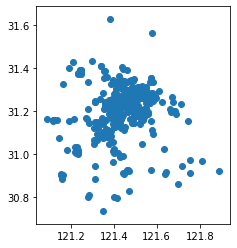

In [206]:
gdf.plot()

## Check if the point is included in polygon

In [207]:
happiness = {}
total = 0
sum_mean = 0
for index, polygon in df_poi_per_district['geometry'].items():
    for mean, point in zip(df_ML['mean'], df_ML['geometry']):
        if point.within(polygon) == True:
            sum_mean += mean
            total += 1
    if total != 0 : 
        happiness[index] = sum_mean/total
    else:
        happiness[index] = 0
    sum_mean = 0
    total = 0

In [208]:
df_poi_per_district['happiness'] = happiness.values()

In [209]:
df_poi_per_district

,NAME,TYPE,geometry,restaurant,Bicycle_park,Bus,Railway_station_entrance_exit,Convenience Store,Scenic_spot,Sport,happiness
0,??,2,POLYGON Z ((121.4216787977396 30.6847124112995...,0,0,0,0,0,0,0,0.000000
1,???,2,POLYGON Z ((121.4119888989075 30.6937387337238...,0,0,0,0,0,0,0,0.000000
2,???,2,POLYGON Z ((121.4016307330431 30.7071734919907...,0,0,0,0,0,0,0,0.000000
3,????,2,POLYGON Z ((121.3368669670694 30.7380603821550...,748,197,0,0,134,28,229,0.000000
4,????,2,POLYGON Z ((121.2514316037695 30.7917653095429...,616,335,0,3,163,9,111,0.000000
5,???,2,POLYGON Z ((121.361791867899 30.80039372730244...,1131,333,0,5,128,14,167,2.666667
6,???,2,POLYGON Z ((121.1946455066587 30.8145337554495...,86,114,0,0,22,9,15,0.000000
7,???,2,POLYGON Z ((121.2968222983408 30.8189104622134...,177,190,0,8,55,12,37,2.250000
8,???,2,POLYGON Z ((121.3671342033205 30.8431074654533...,157,238,0,11,45,2,53,2.666667
9,???,2,POLYGON Z ((121.174529158719 30.87609875249207...,189,222,0,5,66,11,50,0.000000


In [211]:
df_poi_per_district.columns

Index(['NAME', 'TYPE', 'geometry', 'restaurant', 'Bicycle_park', 'Bus',
       'Railway_station_entrance_exit', 'Convenience Store', 'Scenic_spot',
       'Sport', 'happiness'],
      dtype='object')

## Classification

In [363]:
#X = df_poi_per_district[['restaurant', 'Bicycle_park', 'Bus', 'Railway_station_entrance_exit', 'Convenience Store', 'Scenic_spot', 'Sport']]
X = df_poi_per_district[['Convenience Store']]
Y = df_poi_per_district['happiness']

In [364]:
import numpy as np

In [365]:
Z = pd.DataFrame.copy(Y)
Z[Y <= np.median(Y)] = "Unhappy"
Z[Y > np.median(Y)] = "Happy"

##Z[(Y > np.quantile(Y, 0.25)) & (Y <= np.quantile(Y, 0.5))] = "Unhappy"
##Z[(Y > np.quantile(Y, 0.5)) & (Y <= np.quantile(Y, 0.75))] = "Happy"
##Z[Y > np.quantile(Y,0.75)] = "Very Happy"

## Training and Testing 

In [366]:
from sklearn.model_selection import train_test_split
X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.3, shuffle=True)

## Decision Tree

In [367]:
# We want to determine the best CV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
param_grid = {'max_depth': [1,2,4,6,8,10,20,40,100]}
search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv= ShuffleSplit(n_splits=5))
search.fit(X,Z)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=None, train_size=None),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 4, 

In [368]:
search.best_params_

{'max_depth': 1}

##### search.best_params_

In [369]:
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier(max_depth=search.best_params_['max_depth'])

In [370]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=search.best_params_['max_depth'])
clf = clf.fit(X_train, Z_train)
prediction = clf.predict(X_test)
np.mean(prediction == Z_test)

0.675

[Text(418.5, 407.70000000000005, 'X[0] <= 33.5\nentropy = 0.5\nsamples = 186\nvalue = [92, 94]'),
 Text(209.25, 135.89999999999998, 'entropy = 0.043\nsamples = 46\nvalue = [1, 45]'),
 Text(627.75, 135.89999999999998, 'entropy = 0.455\nsamples = 140\nvalue = [91, 49]')]

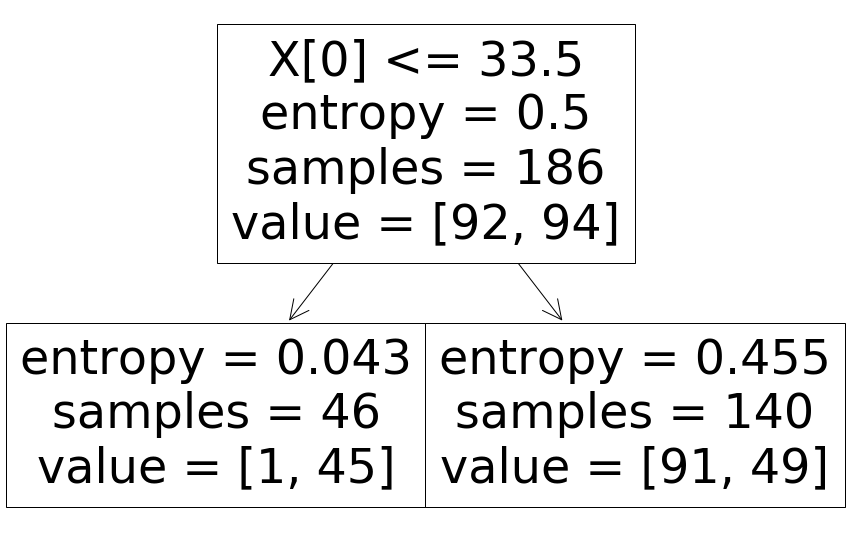

In [371]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
tree.plot_tree(clf)

In [372]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
param_grid={'n_estimators':[10,40,80,90]}
clf=RandomForestClassifier()
search=GridSearchCV(clf,param_grid,cv=5)
search.fit(X_train,Z_train)

C:\Users\Aurelie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [373]:
search.best_params_

{'n_estimators': 40}

In [374]:
clf=RandomForestClassifier(n_estimators=40)
clf.fit(X_train,Z_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [375]:
Z_pred=clf.predict(X_test)

In [376]:
np.mean(Z_pred == Z_test)

0.6375

## AdaBoost

In [377]:
# We  want to determine the best param
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
param_grid = {'n_estimators': [10, 50, 100]}
clf = AdaBoostClassifier()
search = GridSearchCV(clf, param_grid, cv= 5)
search.fit(X_train, Z_train)

C:\Users\Aurelie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [378]:
#best model
clf = AdaBoostClassifier(n_estimators=50)
clf = clf.fit(X_train, Z_train)
prediction = clf.predict(X_test)
np.mean(prediction == Z_test)

0.675